In [108]:
## load modules and run mlflow_logging.ipynb to get function to track model information on MLFLow
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt


from modeling.functions import modelling, log_to_mlflow, get_features, save_models, load_models, save_results

In [25]:
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'], index_col= 'TIMESTAMP')
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'])
data.head()
data.info()
RSEED = 42

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175440 entries, 2012-01-01 01:00:00 to 2014-01-01 00:00:00
Data columns (total 48 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ZONEID         175440 non-null  int64  
 1   TARGETVAR      175265 non-null  float64
 2   U10            175440 non-null  float64
 3   V10            175440 non-null  float64
 4   U100           175440 non-null  float64
 5   V100           175440 non-null  float64
 6   HOUR           175440 non-null  int64  
 7   MONTH          175440 non-null  int64  
 8   WEEKDAY        175440 non-null  int64  
 9   IS_HOLIDAY     175440 non-null  int64  
 10  WS10           175440 non-null  float64
 11  WS100          175440 non-null  float64
 12  WD10           175440 non-null  float64
 13  WD100          175440 non-null  float64
 14  U100NORM       175440 non-null  float64
 15  V100NORM       175440 non-null  float64
 16  WD100CARD_E    175440 non-null  uint8  


## Fill NaNs

In [105]:
# delete last day
data_ts = data[:'2013-12-31 00:00:00']
data_ts.interpolate(method='linear', inplace = True)

In [106]:
## train-test-split
data_train = data_ts[:'2013-07-01 00:00:00']

data_test = data_ts['2013-07-01 01:00:00':]

#data_train.tail()
data_test.head()

,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-07-01 01:00:00,1,0.625035,5.896003,-1.520128,9.461001,-2.106530,1,7,0,0,...,0,0,0,0,0,0,0,0,1,0
2013-07-01 02:00:00,1,0.791185,5.886435,-0.900037,9.019789,-1.276092,2,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-07-01 03:00:00,1,0.867400,5.899591,-0.693670,8.685795,-1.147814,3,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-07-01 04:00:00,1,0.896814,5.807502,-0.680772,8.629487,-1.117739,4,7,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-07-01 05:00:00,1,0.647214,4.936254,-0.752703,7.652959,-1.130014,5,7,0,0,...,0,0,0,0,0,0,0,1,0,0


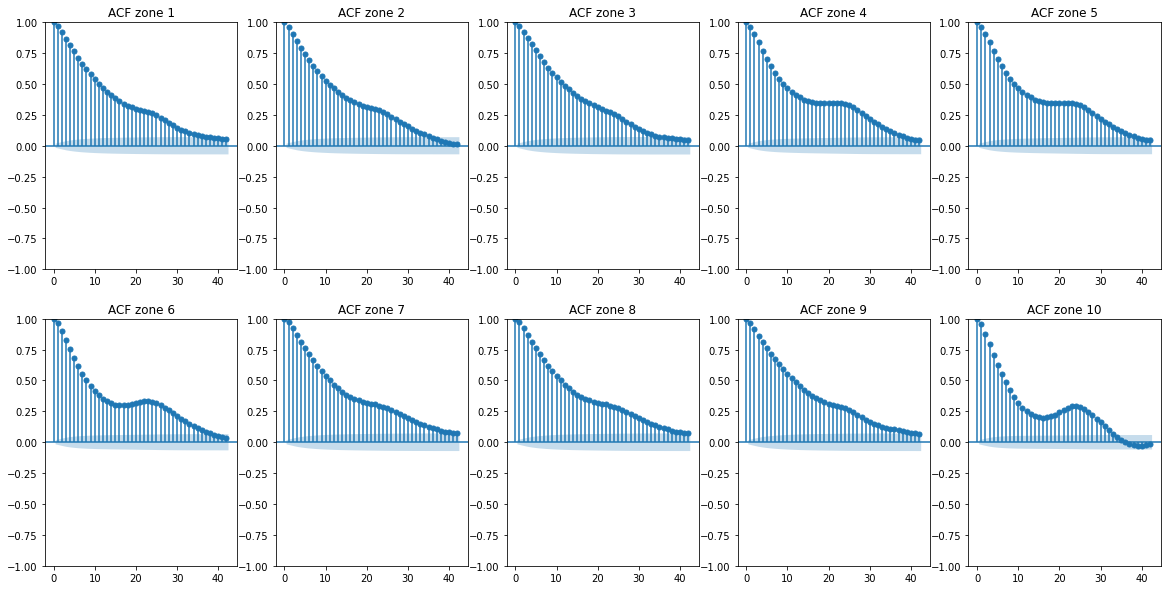

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2,5, figsize = (20,10))
axs = axs.ravel()

for i, zone in enumerate(data_train.ZONEID.unique()):
    plot_acf(data_train[data_train.ZONEID == zone]['WS100'], title = 'ACF zone '+str(zone), ax = axs[i])
plt.show()
#plot_acf(data_train.TARGETVAR)

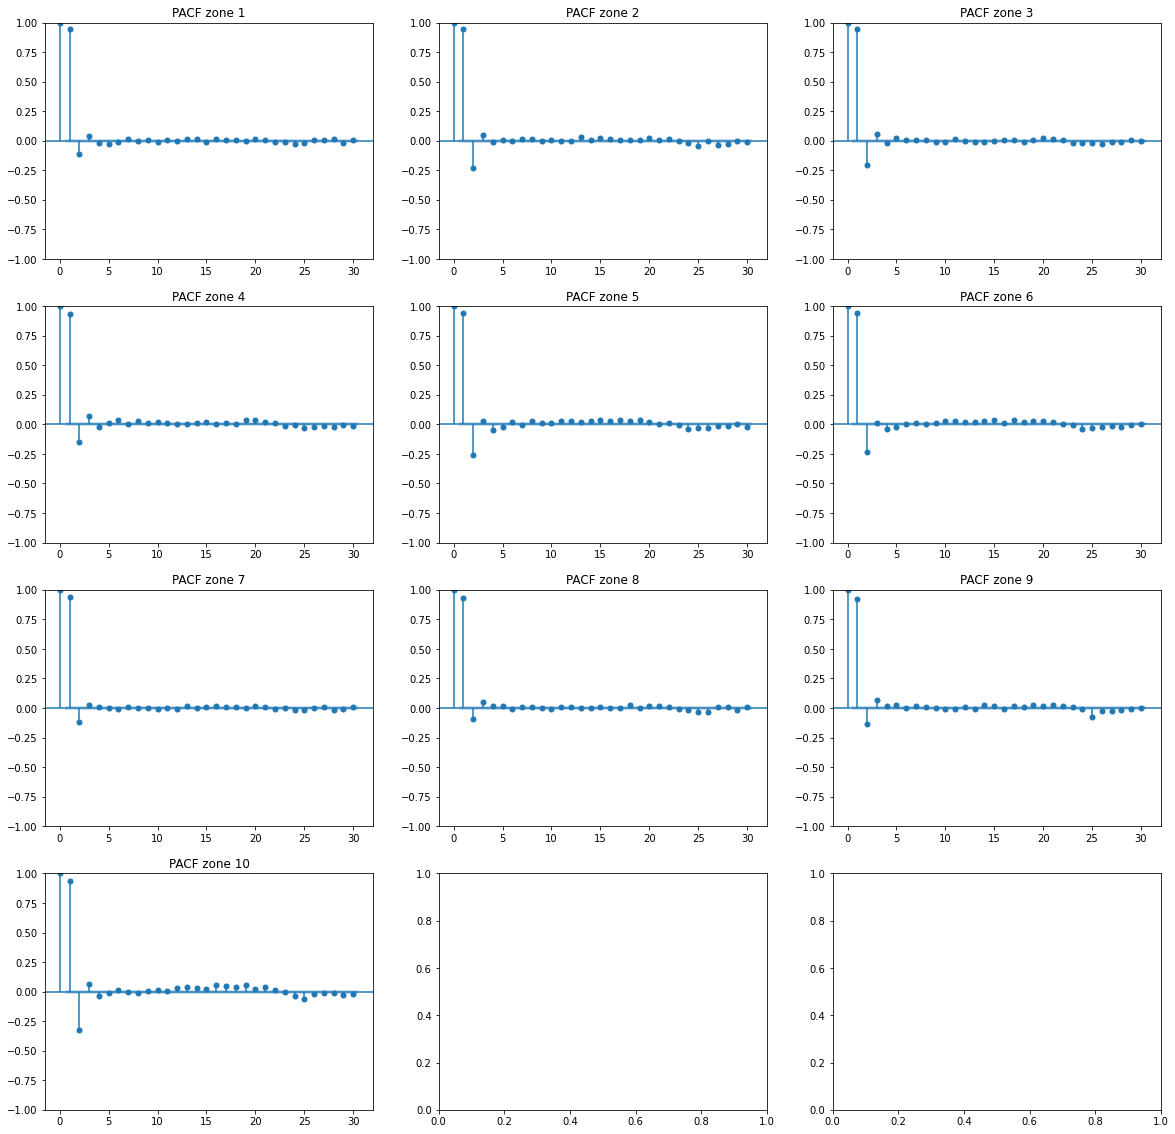

In [169]:
fig, axs = plt.subplots(4,3, figsize = (20,20))
axs = axs.ravel()

for i, zone in enumerate(data_train.ZONEID.unique()):
    plot_pacf(data_train[data_train.ZONEID == zone]['TARGETVAR'], title = 'PACF zone '+str(zone), ax = axs[i], lags=30)
plt.show()

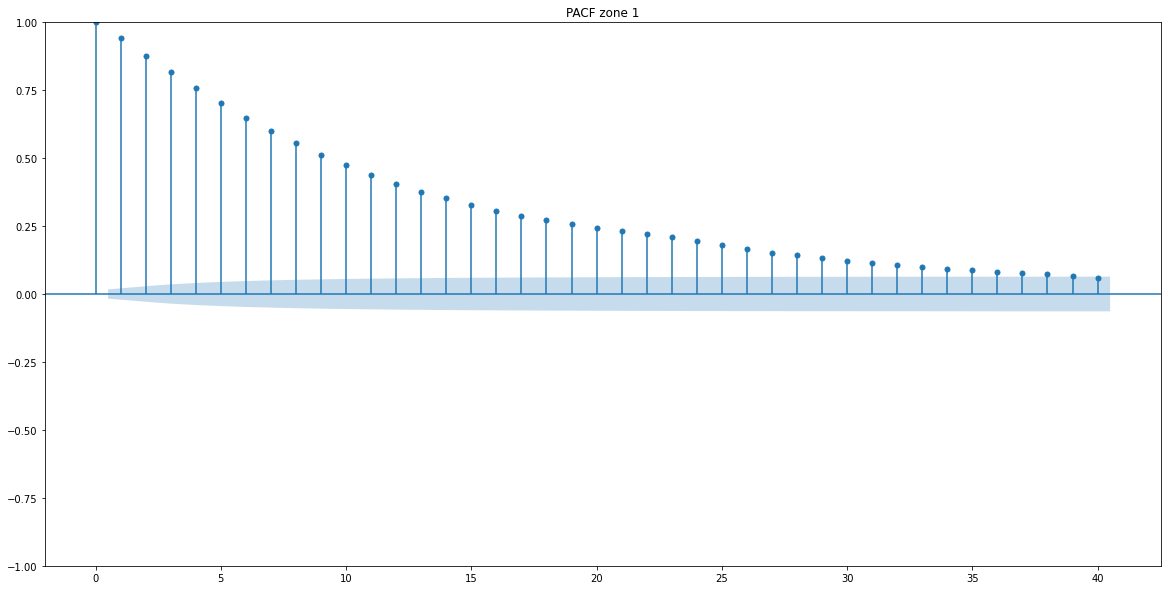

In [126]:
fig, ax = plt.subplots(figsize = (20,10))
#axs = axs.ravel()

zone = 1
plot_acf(data_train[data_train.ZONEID == zone]['TARGETVAR'], title = 'PACF zone '+str(zone), ax = ax, lags=40)
plt.show()

In [131]:
from statsmodels.tsa.arima.model import ARIMA
zone = 1
data_train_1 = data_train[data_train.ZONEID == zone]
data_test_1 = data_test[data_test.ZONEID == zone]

model = ARIMA(endog = data_train_1['TARGETVAR'], order = (2, 0, 24))
model_fit = model.fit()

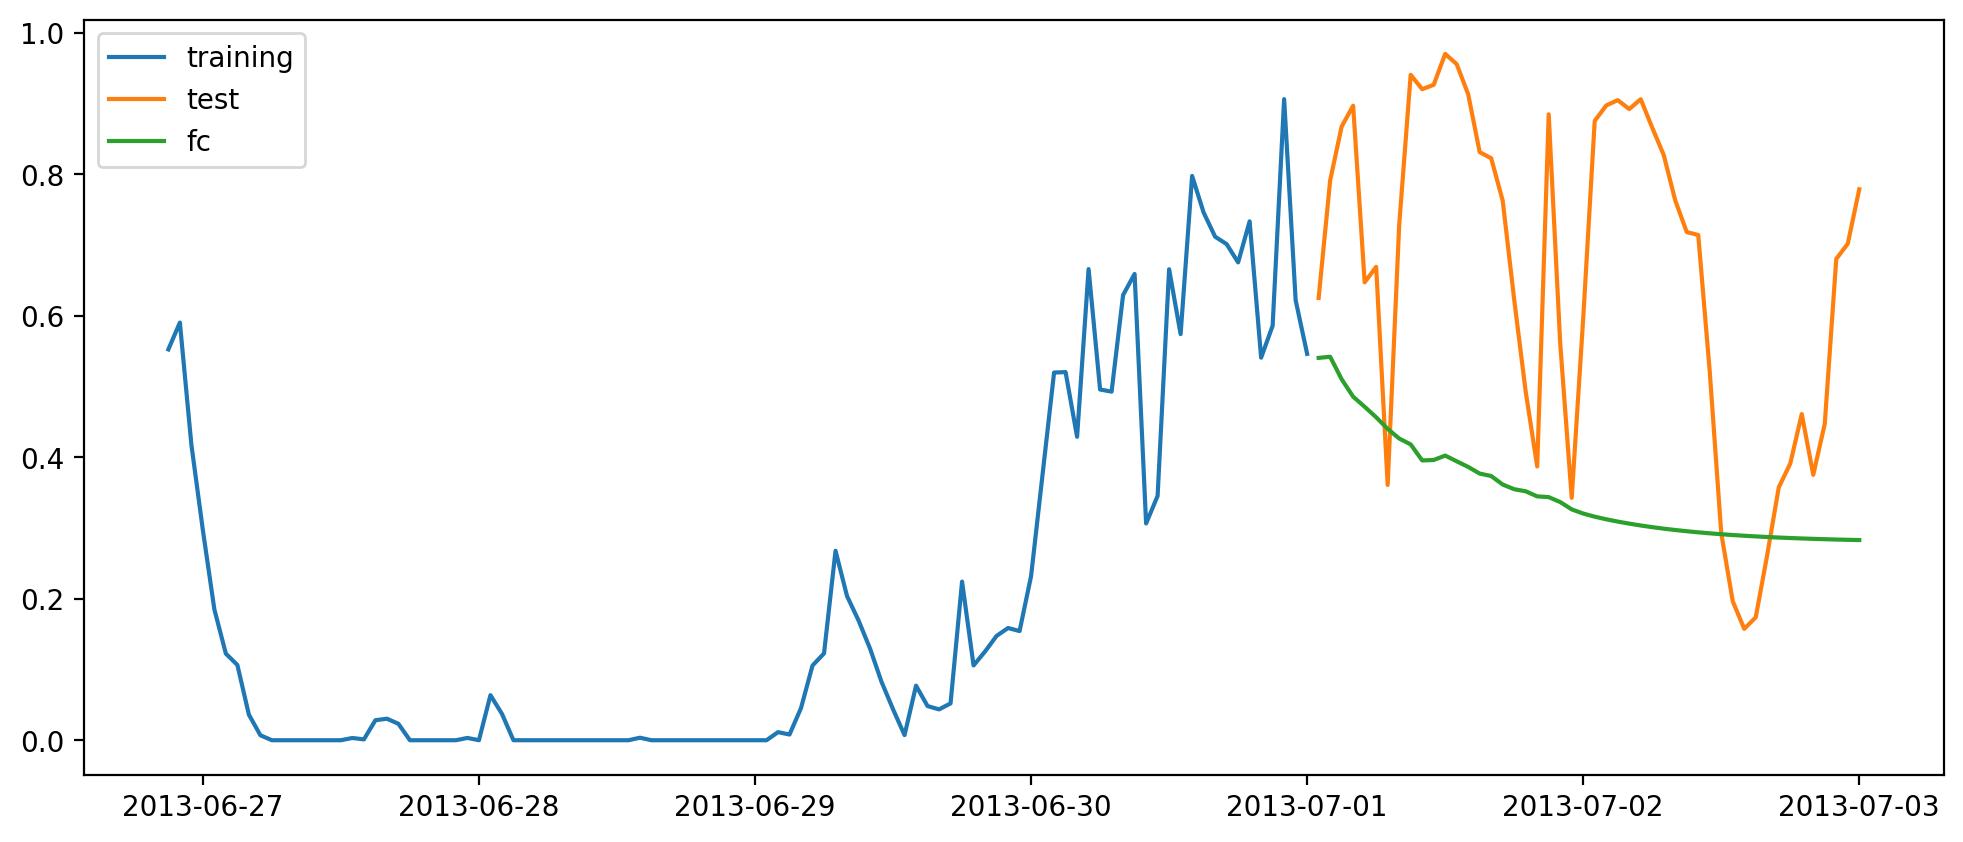

In [144]:
fc = model_fit.forecast(48)

fc_series = pd.Series(fc, index = data_test.iloc[:48].index)

plt.figure(figsize=(12,5), dpi = 200)
plt.plot(data_train_1.iloc[-100:]['TARGETVAR'], label = 'training')
plt.plot(data_test_1.iloc[:48]['TARGETVAR'], label = 'test')
plt.plot(fc_series, label = 'fc')
plt.legend(loc = 'upper left')
plt.show()

In [155]:
zone = 6
data_train_zone = data_train[data_train.ZONEID == zone]
data_test_zone = data_test[data_test.ZONEID == zone]

model_WS100 = ARIMA(endog = data_train_zone['TARGETVAR'], exog = data_train_zone['WS100'], order = (2, 0, 24))
model_fit_WS100 = model_WS100.fit()

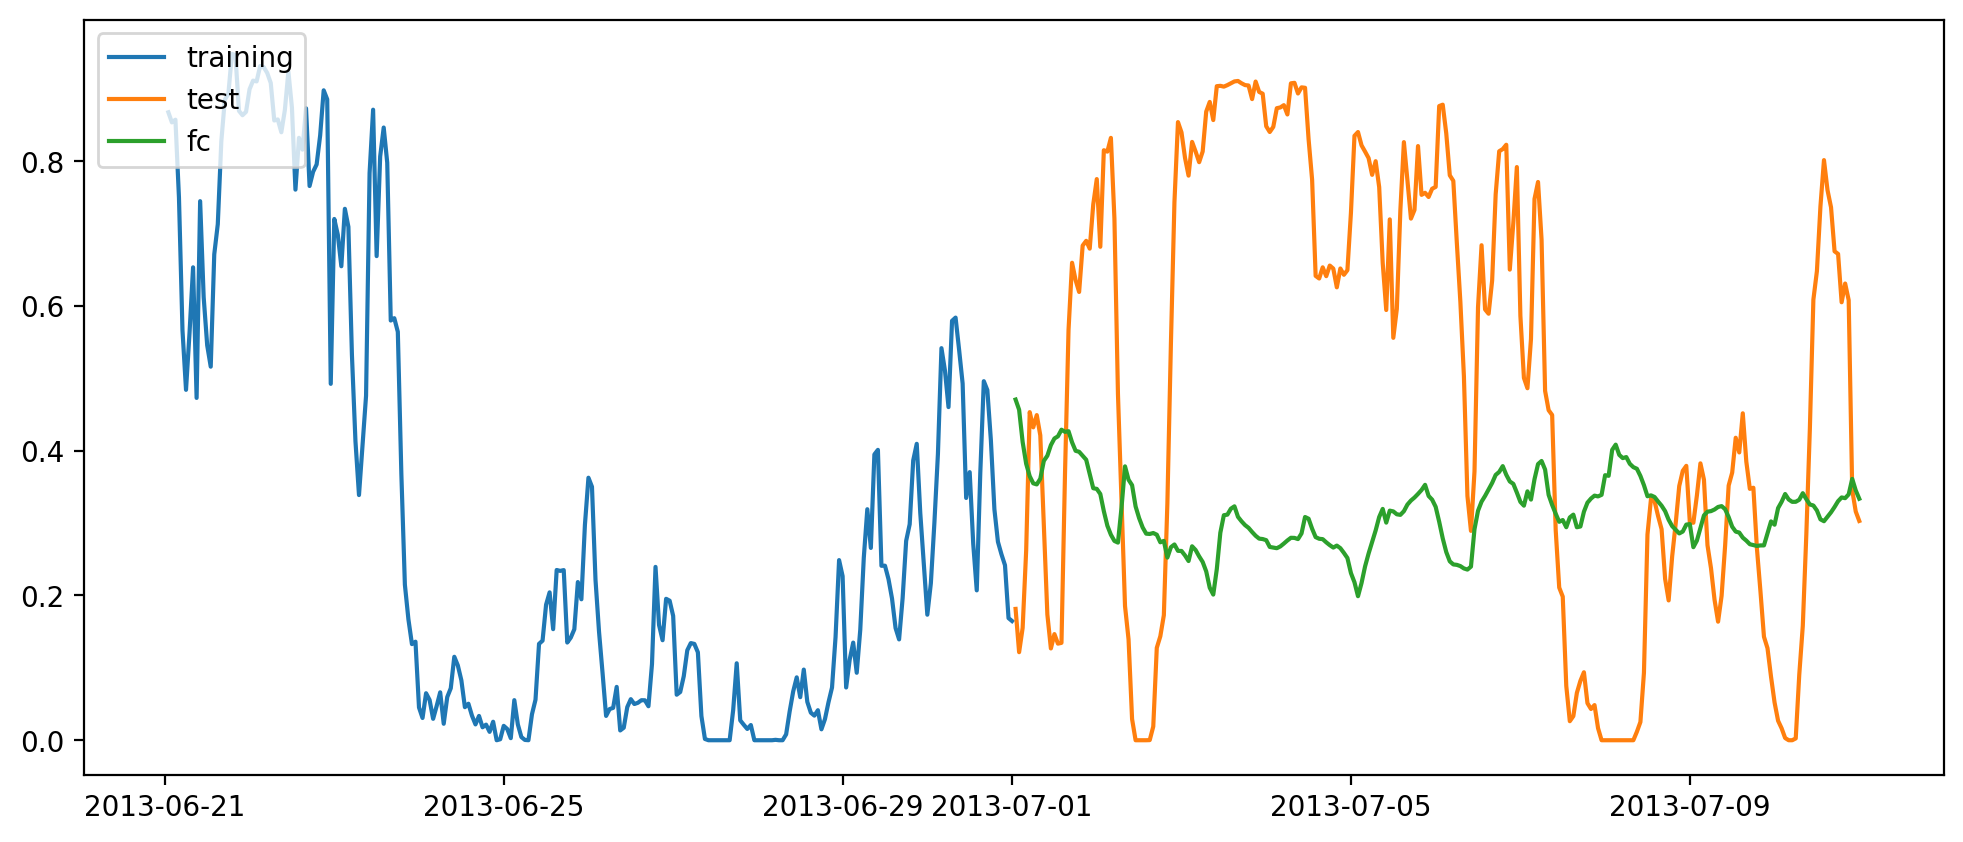

In [153]:
fc = model_fit_WS100.forecast(240, exog =data_train_zone['WS100'].iloc[:240] )

fc_series = pd.Series(fc, index = data_test_zone.iloc[:240].index)

plt.figure(figsize=(12,5), dpi = 200)
plt.plot(data_train_zone.iloc[-240:]['TARGETVAR'], label = 'training')
plt.plot(data_test_zone.iloc[:24 * 10]['TARGETVAR'], label = 'test')
plt.plot(fc_series, label = 'fc')
plt.legend(loc = 'upper left')
plt.show()

In [163]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(endog = data_train_zone['TARGETVAR'], exog = data_train_zone['WS100'], order = (0, 0, 0), seasonal_order= (1, 0, 0, 24))
model_sarima_fitted = model_sarima.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20848D-01    |proj g|=  8.84267D-01

At iterate    5    f= -1.21371D-01    |proj g|=  1.91852D-02

At iterate   10    f= -1.21391D-01    |proj g|=  8.27447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   1.523D-05  -1.214D-01
  F = -0.12139138368404778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [164]:
model_sarima_fitted.params

WS100       0.069857
ar.S.L24    0.195359
sigma2      0.045924
dtype: float64

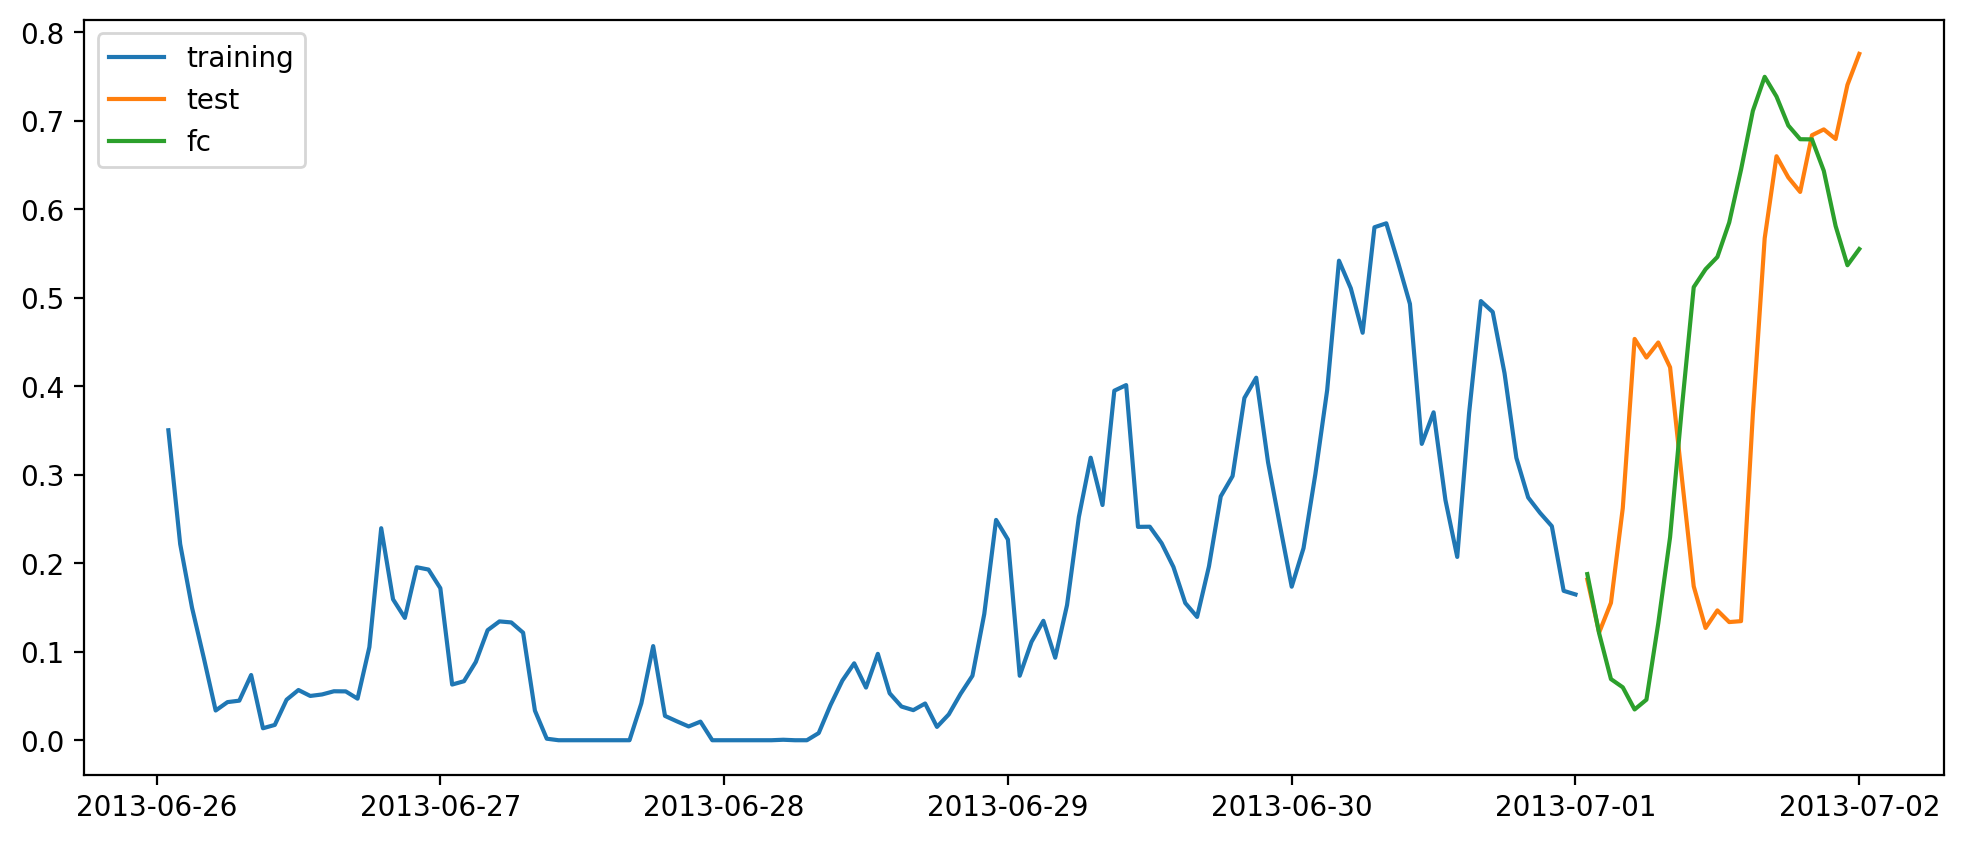

In [166]:
fc = model_sarima_fitted.forecast(24, exog =data_train_zone['WS100'].iloc[:24] )

fc_series = pd.Series(fc, index = data_test_zone.iloc[:24].index)
test_series = data_test_zone.iloc[:24]['TARGETVAR']

plt.figure(figsize=(12,5), dpi = 200)
plt.plot(data_train_zone.iloc[-120:]['TARGETVAR'], label = 'training')
plt.plot(test_series, label = 'test')
plt.plot(fc_series, label = 'fc')
plt.legend(loc = 'upper left')
plt.show()

In [167]:
mean_squared_error(test_series, fc_series, squared = False)

0.26479407551661915

## EDA Time Series

In [90]:
consecutive = data_ts[data_ts.TARGETVAR.isna()][['TARGETVAR', 'ZONEID']]

zone_1 = consecutive[consecutive.ZONEID == 1]
zone_3 =  data[data.ZONEID == 3]


In [83]:
time_delta =  pd.Timedelta('0 days 01:00:00')

zone_lst = []
nan_lst = []
idx_list = []

for zone in consecutive.ZONEID.unique():
    consecutive_counter = 1
    zone_df = consecutive[consecutive.ZONEID == zone]
    rows = zone_df.shape[0]
    counter = 0
    print(zone)
    for idx, row in zone_df.iterrows():
        if counter < rows - 1:
            next_idx = idx + time_delta
            try:
                zone_df.loc[next_idx]
            except KeyError:
                print(next_idx)
                nan_lst.append(consecutive_counter)
                zone_lst.append(zone)
                idx_list.append(next_idx)
                consecutive_counter = 1
            else: 
                consecutive_counter += 1                

            counter += 1
        else:
            break

1
2013-04-22 10:00:00
2013-05-17 06:00:00
2013-05-23 06:00:00
2013-06-13 00:00:00
2013-06-19 06:00:00
2013-07-11 01:00:00
2013-08-15 17:00:00
2013-09-20 05:00:00
2013-10-22 03:00:00
2013-11-01 02:00:00
2
2013-04-22 10:00:00
2013-05-17 06:00:00
2013-05-22 09:00:00
2013-05-23 06:00:00
2013-05-24 01:00:00
2013-07-11 01:00:00
2013-07-23 09:00:00
2013-09-20 05:00:00
2013-10-30 22:00:00
2013-11-01 02:00:00
2013-11-01 17:00:00
2013-11-03 00:00:00
3
2013-07-09 03:00:00
2013-07-16 01:00:00
2013-07-18 03:00:00
2013-07-25 03:00:00
2013-07-29 02:00:00
2013-07-30 17:00:00
2013-07-31 03:00:00
2013-08-07 06:00:00
2013-08-08 10:00:00
2013-08-24 07:00:00
2013-08-26 16:00:00
2013-08-30 19:00:00
2013-09-02 12:00:00
2013-09-05 03:00:00
2013-09-08 08:00:00
2013-09-14 00:00:00
2013-09-14 05:00:00
2013-09-14 08:00:00
2013-09-14 11:00:00
2013-09-14 14:00:00
2013-09-16 19:00:00
2013-09-17 03:00:00
2013-09-17 19:00:00
2013-09-17 21:00:00


In [84]:
results = pd.DataFrame({'zone': zone_lst, 'nans': nan_lst, 'last_index': idx_list})
results.sort_values(by = 'nans', ascending=False)

# for zone, nans in zip(zone_lst, nan_lst):
#     print(zone, nans)

,zone,nans,last_index
34,3,20,2013-09-02 12:00:00
32,3,11,2013-08-26 16:00:00
27,3,10,2013-07-30 17:00:00
36,3,8,2013-09-08 08:00:00
42,3,6,2013-09-16 19:00:00
30,3,6,2013-08-08 10:00:00
38,3,3,2013-09-14 05:00:00
31,3,3,2013-08-24 07:00:00
33,3,3,2013-08-30 19:00:00
12,2,2,2013-05-22 09:00:00


<AxesSubplot:xlabel='TIMESTAMP'>

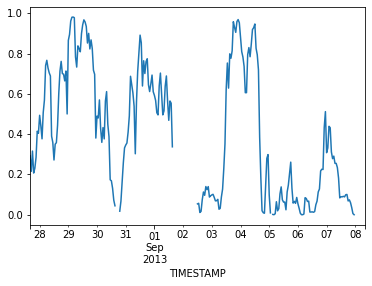

In [95]:
end_idx = pd.to_datetime('2013-09-02 12:00:00')
time_delta_ = pd.Timedelta('5 days 20:00:00')
zone_3.loc[end_idx - time_delta_ :end_idx + time_delta_]['TARGETVAR'].plot()

In [23]:

data.interpolate(pad = 'index', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175200 entries, 2012-01-01 01:00:00 to 2013-12-31 00:00:00
Data columns (total 48 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ZONEID         175200 non-null  int64  
 1   TARGETVAR      175200 non-null  float64
 2   U10            175200 non-null  float64
 3   V10            175200 non-null  float64
 4   U100           175200 non-null  float64
 5   V100           175200 non-null  float64
 6   HOUR           175200 non-null  int64  
 7   MONTH          175200 non-null  int64  
 8   WEEKDAY        175200 non-null  int64  
 9   IS_HOLIDAY     175200 non-null  int64  
 10  WS10           175200 non-null  float64
 11  WS100          175200 non-null  float64
 12  WD10           175200 non-null  float64
 13  WD100          175200 non-null  float64
 14  U100NORM       175200 non-null  float64
 15  V100NORM       175200 non-null  float64
 16  WD100CARD_E    175200 non-null  uint8  


True